## Step 1: Data Collection and API Integration

### Food-101 Dataset

The **Food-101** dataset is a large-scale collection of food images designed for visual recognition tasks.  
It contains **101 categories** of food, with **1,000 images per class** — 750 for training and 250 for testing.  

Since the dataset was downloaded manually from the official [Food-101 website](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), the extracted directory structure looks like this:



<pre>

food-101/
├── images/
│   ├── apple_pie/
│   ├── pizza/
│   ├── sushi/
│   └── ...
└── meta/
    ├── train.json
    ├── test.json
    └── classes.txt

</pre>


Each image folder corresponds to a food category (e.g., `pizza`, `sushi`, `apple_pie`).  
The `train.json` and `test.json` files contain mappings of image paths to their corresponding labels.

In [22]:
import json
import os
import pandas as pd

with open('../data/raw/food-101/meta/train.json') as f:
    train_data = json.load(f)
with open('../data/raw/food-101/meta/test.json') as f:
    test_data = json.load(f)

train_list = [(img, label) for label, imgs in train_data.items() for img in imgs]
test_list = [(img, label) for label, imgs in test_data.items() for img in imgs]

train_df = pd.DataFrame(train_list, columns=['image_name', 'label'])
test_df = pd.DataFrame(test_list, columns=['image_name', 'label'])

usda_df = pd.read_csv("../data/raw/usda_food_data.csv")
merged_train = train_df.merge(usda_df, left_on='label', right_on='description', how='left')

merged_train.to_csv("../data/clean/train_cleaned.csv", index=False)
test_df.to_csv("../data/clean/test_cleaned.csv", index=False)

print("Data cleaning complete — saved train_cleaned.csv and test_cleaned.csv")

Data cleaning complete — saved train_cleaned.csv and test_cleaned.csv


In [23]:
train_df = pd.read_csv("../data/clean/train_cleaned.csv")
test_df = pd.read_csv("../data/clean/test_cleaned.csv")

print("Datasets successfully loaded")
print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

Datasets successfully loaded
Training set shape: (75750, 7)
Testing set shape: (25250, 2)


In [24]:
print("\nTraining Data Info:")
print(train_df.info())

print("\nFirst 5 rows of Training Data:")
display(train_df.head())

print("\n Number of unique labels (food classes):", train_df['label'].nunique())
print("\n Sample labels:", train_df['label'].unique()[:10])


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75750 entries, 0 to 75749
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image_name   75750 non-null  object 
 1   label        75750 non-null  object 
 2   fdcId        0 non-null      float64
 3   description  0 non-null      float64
 4   dataType     0 non-null      float64
 5   calories     0 non-null      float64
 6   unit         0 non-null      float64
dtypes: float64(5), object(2)
memory usage: 4.0+ MB
None

First 5 rows of Training Data:


,image_name,label,fdcId,description,dataType,calories,unit
0,churros/1004234,churros,NaN,NaN,NaN,NaN,NaN
1,churros/1013460,churros,NaN,NaN,NaN,NaN,NaN
2,churros/1016791,churros,NaN,NaN,NaN,NaN,NaN
3,churros/102100,churros,NaN,NaN,NaN,NaN,NaN
4,churros/1025494,churros,NaN,NaN,NaN,NaN,NaN



 Number of unique labels (food classes): 101

 Sample labels: ['churros' 'hot_and_sour_soup' 'samosa' 'sashimi' 'pork_chop'
 'spring_rolls' 'panna_cotta' 'beef_tartare' 'greek_salad' 'foie_gras']


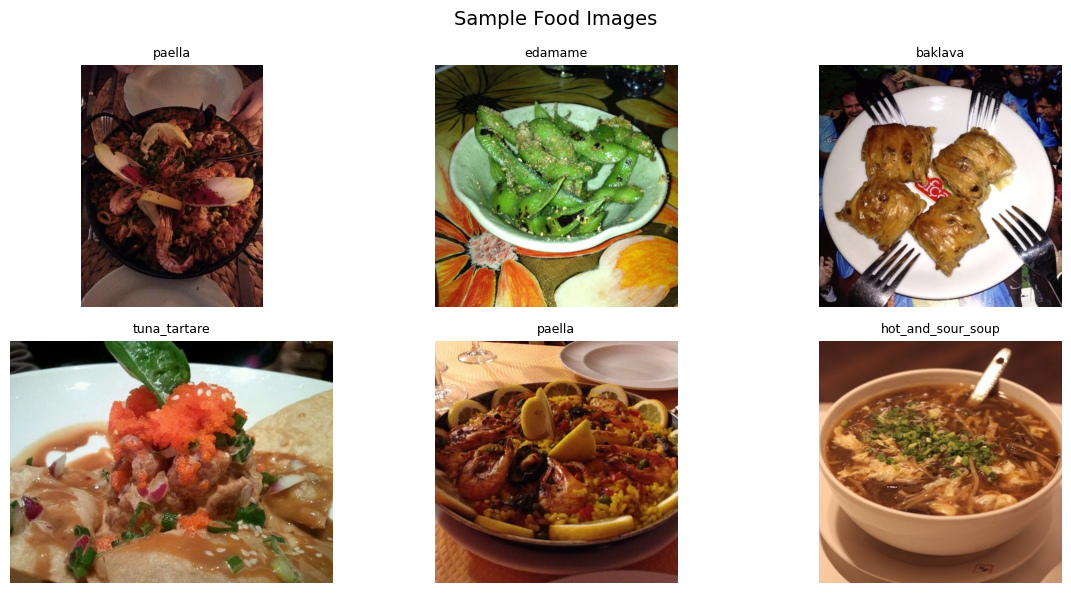

In [25]:
import matplotlib.pyplot as plt
from PIL import Image

def show_sample_images(df, base_path="../data/raw/food-101/images", n=6):
    sample_rows = df.sample(n)
    fig, axes = plt.subplots(2, n//2, figsize=(12, 6))
    axes = axes.flatten()

    for i, (_, row) in enumerate(sample_rows.iterrows()):
        img_path = os.path.join(base_path, f"{row['image_name']}.jpg")
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(row['label'], fontsize=9)
            axes[i].axis("off")
        else:
            axes[i].text(0.5, 0.5, "Image not found", ha='center', va='center')
            axes[i].set_axis_off()

    plt.suptitle("Sample Food Images", fontsize=14)
    plt.tight_layout()
    plt.show()

show_sample_images(train_df)

In [26]:
import tensorflow as tf

IMG_SIZE = 128
BATCH_SIZE = 32

train_df = pd.read_csv("../data/clean/train_cleaned.csv")
test_df = pd.read_csv("../data/clean/test_cleaned.csv")

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    return image

def get_image_path(image_name):
    return os.path.join("../data/raw/food-101/images", image_name + ".jpg")

train_df["image_path"] = train_df["image_name"].apply(get_image_path)

train_ds = tf.data.Dataset.from_tensor_slices((train_df["image_path"], train_df["label"]))
train_ds = train_ds.map(lambda x, y: (load_and_preprocess_image(x), y))
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

---

### USDA FoodData Central API Integration

To enhance the dataset with **nutritional information**, we integrated the **USDA FoodData Central API**, a public database providing nutrient composition data for thousands of food items.

The following Python code demonstrates how the API was accessed and converted into a CSV file (`usda_food_data.csv`):

In [27]:
import requests
import pandas as pd

api_key = "cPZExQIH2MXPTmWaxWVVLnN2Nz4tlpjQihbcYZCy"
food_query = "apple pie"

url = f"https://api.nal.usda.gov/fdc/v1/foods/search?query={food_query}&api_key={api_key}"
response = requests.get(url).json()

print(response)


foods = []
for food in response["foods"]:
    foods.append({
        "fdcId": food["fdcId"],
        "description": food["description"],
        "dataType": food["dataType"],
        "calories": food.get("foodNutrients", [{}])[0].get("value", None),
        "unit": food.get("foodNutrients", [{}])[0].get("unitName", None)
    })

usda_df = pd.DataFrame(foods)
usda_df.to_csv("../data/raw/usda_food_data.csv", index=False)
print("Saved food data to usda_food_data.csv")

{'totalHits': 30149, 'currentPage': 1, 'totalPages': 603, 'pageList': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'foodSearchCriteria': {'query': 'apple pie', 'generalSearchInput': 'apple pie', 'pageNumber': 1, 'numberOfResultsPerPage': 50, 'pageSize': 50, 'requireAllWords': False}, 'foods': [{'fdcId': 2288447, 'description': 'APPLE PIE', 'dataType': 'Branded', 'gtinUpc': '070953605010', 'publishedDate': '2022-05-23', 'brandOwner': 'Carolina Foods Inc.', 'brandName': 'DUCHESS', 'ingredients': 'ENRICHED BLEACHED WHEAT FLOUR (BLEACHED FLOUR, MALTED BARLEY FLOUR, NIACIN, REDUCED IRON, THIAMIN MONONITRATE, RIBOFLAVIN, FOLIC ACID), WATER, SUGAR, VEGETABLE OIL (CONTAINS ONE OR MORE OF THE FOLLOWING OILS: COTTONSEED OIL, PALM OIL, SOYBEAN OIL), HIGH FRUCTOSE CORN SYRUP, GLYCERIN, CORN SYRUP, APPLES, CONTAINS 2% OR LESS OF THE FOLLOWING: DEXTROSE, MODIFIED CORNSTARCH, APPLE POWDER, SALT, PRESERVATIVES (POTASSIUM SORBATE, SODIUM PROPIONATE, SODIUM BENZOATE, SULFUR DIOXIDE), SODIUM ALGINATE, SODIUM CITRATE